In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


In [3]:
# Set the data directory and image dimensions
data_dir = r'/content/drive/MyDrive/AI-Intern Project/Tea leaf Disease Detection/tea sickness dataset'
img_height, img_width = 224, 224
batch_size = 32

In [4]:
# Set up data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)


In [5]:
# Load and preprocess the training dataset
train_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training')


Found 798 images belonging to 8 classes.


In [7]:
# Load and preprocess the validation dataset
val_data = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 196 images belonging to 8 classes.
Found 196 images belonging to 8 classes.


In [8]:
# Load the InceptionV3 base model without the top layers
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

87910968/87910968 [==============================] - 1s 0us/step


In [9]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

In [10]:
# Add custom classification layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(train_data.num_classes, activation='softmax')(x)

In [11]:
# Create the model with InceptionV3 as the base and custom classification layers
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [14]:
# Train the model
history = model.fit(train_data, epochs=25, validation_data=val_data)

Epoch 1/25
25/25 [==============================] - 417s 16s/step - loss: 1.8306 - accuracy: 0.3647 - val_loss: 1.5016 - val_accuracy: 0.3929
Epoch 2/25
25/25 [==============================] - 171s 7s/step - loss: 1.2007 - accuracy: 0.5388 - val_loss: 1.4332 - val_accuracy: 0.4541
Epoch 3/25
25/25 [==============================] - 181s 7s/step - loss: 1.0473 - accuracy: 0.6028 - val_loss: 1.1926 - val_accuracy: 0.4898
Epoch 4/25
25/25 [==============================] - 176s 7s/step - loss: 0.9159 - accuracy: 0.6378 - val_loss: 1.2450 - val_accuracy: 0.5000
Epoch 5/25
25/25 [==============================] - 169s 7s/step - loss: 0.8740 - accuracy: 0.6667 - val_loss: 1.5634 - val_accuracy: 0.3673
Epoch 6/25
25/25 [==============================] - 175s 7s/step - loss: 0.8239 - accuracy: 0.6629 - val_loss: 1.0581 - val_accuracy: 0.5816
Epoch 7/25
25/25 [==============================] - 175s 7s/step - loss: 0.8006 - accuracy: 0.6667 - val_loss: 1.3095 - val_accuracy: 0.4796
Epoch 8/25
2

In [15]:
# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_data)
print(f'Validation Loss: {val_loss:.4f}')
print(f'Validation Accuracy: {val_accuracy:.4f}')

7/7 [==============================] - 38s 5s/step - loss: 1.1039 - accuracy: 0.6122
Validation Loss: 1.1039
Validation Accuracy: 0.6122


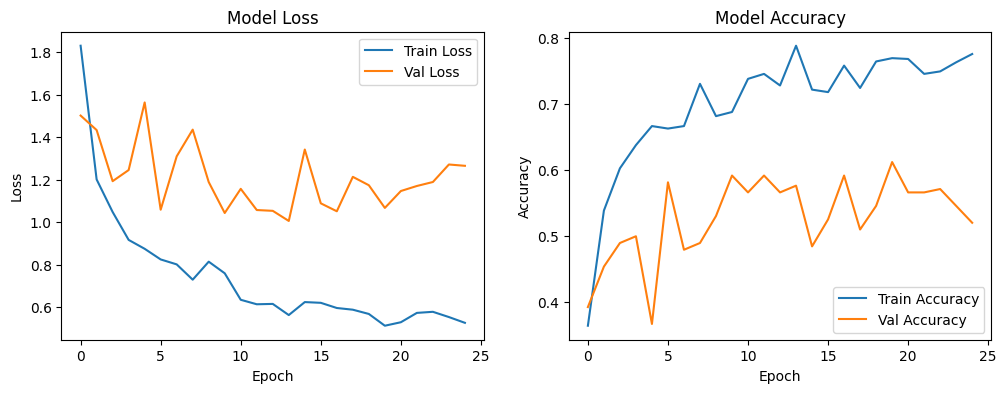

In [16]:
# Plot loss and accuracy
def plot_metrics(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_metrics(history)

In [17]:
# Load and preprocess the test dataset
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.6)
test_data = test_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation')

Found 593 images belonging to 8 classes.


In [18]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_data)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

19/19 [==============================] - 102s 5s/step - loss: 0.6332 - accuracy: 0.7555
Test Loss: 0.6332
Test Accuracy: 0.7555


In [19]:
# Get true and predicted labels for the test dataset
true_labels = test_data.classes
predicted_labels = model.predict(test_data)
predicted_labels = np.argmax(predicted_labels, axis=1)


19/19 [==============================] - 104s 5s/step


In [20]:
# Generate and print classification report
print(classification_report(true_labels, predicted_labels, target_names=list(test_data.class_indices.keys())))


               precision    recall  f1-score   support

  Anthracnose       0.07      0.05      0.06        60
   algal leaf       0.09      0.06      0.07        66
bird eye spot       0.26      0.28      0.27       127
 brown blight       0.10      0.12      0.11        67
   gray light       0.09      0.15      0.12        60
      healthy       0.14      0.12      0.12        43
red leaf spot       0.15      0.12      0.13        85
   white spot       0.16      0.14      0.15        85

     accuracy                           0.15       593
    macro avg       0.13      0.13      0.13       593
 weighted avg       0.14      0.15      0.14       593



1/1 [==============================] - 5s 5s/step


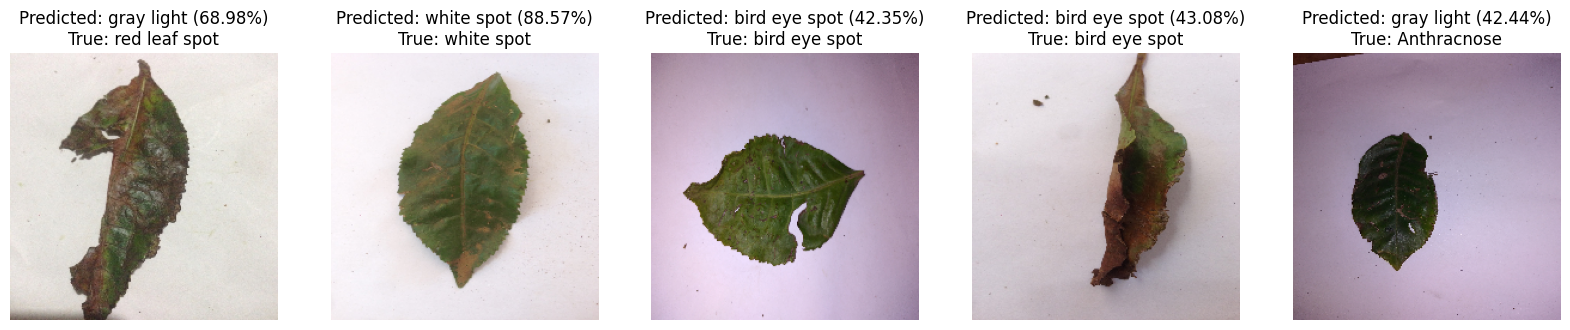

In [21]:
# Plot sample predictions with confidence percentages
def plot_sample_predictions(test_data, model, num_images=5):
    test_images, test_labels = next(test_data)
    predictions = model.predict(test_images)
    predicted_labels = np.argmax(predictions, axis=1)
    class_names = list(test_data.class_indices.keys())
    true_labels = np.argmax(test_labels, axis=1)

    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(test_images[i])
        ax.axis('off')
        predicted_class = class_names[predicted_labels[i]]
        true_class = class_names[true_labels[i]]
        confidence = np.max(predictions[i]) * 100
        ax.set_title(f"Predicted: {predicted_class} ({confidence:.2f}%)\nTrue: {true_class}")

    plt.show()

plot_sample_predictions(test_data, model)

In [23]:
model.save("/content/drive/MyDrive/AI-Intern Project/Tea leaf Disease Detection/saved models/Inception1.h5")